In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, MaxPooling2D ,Conv2D, Flatten, GlobalMaxPool2D
from tensorflow.keras.applications import Xception, mobilenet_v3, vgg16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras import layers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
baseDir = '/kaggle/input/eyepacs-airogs-light/release-crop/release-crop/'
testDir = baseDir + 'test'
trainDir = baseDir + 'train'
validDir = baseDir + 'validation'

In [3]:
img_width, img_height = 224,224
batch_size = 32
num_epochs = 50

# Generator Setup and Data Augmentation

In [4]:
val_datagen = ImageDataGenerator(rescale = 1. / 255)
train_datagen = ImageDataGenerator(#rotation_range=90,
                                    #brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     #validation_split=0.15,
                                    #preprocessing_function=preprocess_input,
                                    zoom_range=0.15,
                                    fill_mode="constant",
                                    cval=0.1,
                                    rescale = 1. / 255)

test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [5]:
train_generator = train_datagen.flow_from_directory(
    directory=trainDir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True
)

validation_generator = val_datagen.flow_from_directory(
    directory=validDir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False
)

test_generator =  test_datagen.flow_from_directory(
    testDir,
    batch_size=batch_size,
    class_mode='binary',
    target_size=(img_width, img_height),
    shuffle = False
)

Found 5000 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Fine-tuning and Regularization

In [6]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=3,
                              verbose=1,
                              mode='auto',
                              min_lr=0)

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience = 15, 
                               mode='auto',
                               min_delta = 0.001)


base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False,
                                                        input_shape=(img_width, img_height, 3), 
                                                        classifier_activation='sigmoid')
base_model.trainable = True
#for layer in base_model.layers[:108]:
 #   layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)


219055592/219055592 [==============================] - 1s 0us/step


# Training

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
          loss='binary_crossentropy',
          metrics=['binary_accuracy',tf.keras.metrics.AUC(),tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=[lr_reduce, early_stopping],
    verbose = 2
)

Epoch 1/50
157/157 - 200s - loss: 0.5984 - binary_accuracy: 0.6898 - auc: 0.7554 - precision: 0.6913 - recall: 0.6860 - val_loss: 0.9389 - val_binary_accuracy: 0.7519 - val_auc: 0.8264 - val_precision: 0.8617 - val_recall: 0.6000 - lr: 0.0010 - 200s/epoch - 1s/step
Epoch 2/50
157/157 - 67s - loss: 0.5279 - binary_accuracy: 0.7504 - auc: 0.8213 - precision: 0.7494 - recall: 0.7524 - val_loss: 0.7441 - val_binary_accuracy: 0.6704 - val_auc: 0.8588 - val_precision: 0.9600 - val_recall: 0.3556 - lr: 0.0010 - 67s/epoch - 426ms/step
Epoch 3/50
157/157 - 67s - loss: 0.4627 - binary_accuracy: 0.7868 - auc: 0.8639 - precision: 0.7766 - recall: 0.8052 - val_loss: 0.4859 - val_binary_accuracy: 0.8093 - val_auc: 0.8961 - val_precision: 0.8523 - val_recall: 0.7481 - lr: 0.0010 - 67s/epoch - 424ms/step
Epoch 4/50
157/157 - 67s - loss: 0.4425 - binary_accuracy: 0.7956 - auc: 0.8780 - precision: 0.7894 - recall: 0.8064 - val_loss: 0.4930 - val_binary_accuracy: 0.8852 - val_auc: 0.9330 - val_precision:

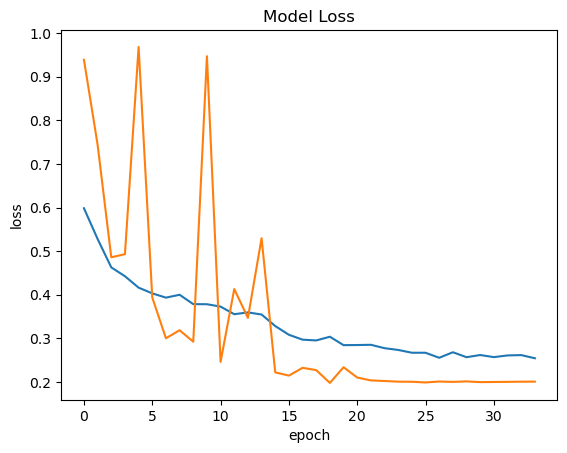

In [8]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

# Testing

32/32 - 7s - loss: 0.1905 - binary_accuracy: 0.9210 - auc: 0.9783 - precision: 0.9087 - recall: 0.9360 - 7s/epoch - 228ms/step


[0.19045984745025635,
 0.9210000038146973,
 0.9782861471176147,
 0.90873783826828,
 0.9359999895095825]

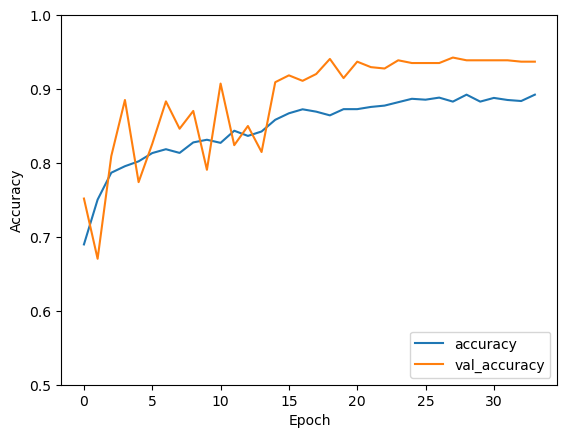

In [9]:
plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

model.evaluate(test_generator, verbose=2)